In [6]:
#Importing Data from the CSV file
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers
from sklearn.svm import SVC as svc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
import seaborn as sns
import time
from scipy import spatial
from itertools import combinations 
import pickle

28*28 - one row size = 784 - one training data

In [2]:
def input_read(file, sep, class0=None, class1=None):
    myFile = pd.read_csv(file, sep=sep, header=None, index_col=False)
    if ((class0!=None) and (class1!=None)):
        df_train = myFile[(myFile.get(784) == class0) | (myFile.get(784) == class1)]
    else: df_train = myFile
    train_classes = df_train[784]
    if ((class0!=None) and (class1!=None)):
        train_classes = (train_classes.apply(lambda x: 1 if (x==class1) else -1))*1.
    train_classes.index = np.arange(0, len(df_train))
    df_train = df_train.drop(784, axis=1)
    df_train.index=(np.arange(0, len(df_train)))
    df_train /= 255
    return df_train.to_numpy(), train_classes.to_numpy();

In [3]:
X_train, train_classes = input_read('fashion_mnist/train.csv', ',')
X_val, val_classes = input_read('fashion_mnist/val.csv', ',')
X_test, test_classes = input_read('fashion_mnist/test.csv', ',')

In [4]:
X_all = np.vstack((X_train, X_val))
classes_xall = np.hstack((train_classes, val_classes)).reshape(-1, 1)
temp = np.hstack((X_all, classes_xall))
np.random.shuffle(temp)
fold1, fold2, fold3, fold4, fold5 = np.split(temp, 5)
fold = [fold1, fold2, fold3, fold4, fold5]
c= [1e-5 , 1e-3 , 0.1, 0.5, 1, 5, 10]

In [5]:
from itertools import combinations
K=5
x = np.arange(K)

train_data = []
val_data = []
comb = [i for i in combinations(x,(K-1))]
print("The combinations of train and val data for 5-fold cross validations are")
for i in comb:
    t = [fold[x] for x in i]
    train_data.append(np.vstack((t[0], t[1], t[2], t[3])))
    rem= np.setdiff1d(x, i)
    val_data.append(fold[rem[0]])
    print("Train Sets = {} Val Set = {}".format(i, rem[0]))

The combinations of train and val data for 5-fold cross validations are
Train Sets = (0, 1, 2, 3) Val Set = 4
Train Sets = (0, 1, 2, 4) Val Set = 3
Train Sets = (0, 1, 3, 4) Val Set = 2
Train Sets = (0, 2, 3, 4) Val Set = 1
Train Sets = (1, 2, 3, 4) Val Set = 0


In [6]:
train_class=[]
val_class=[]
for i in range(len(train_data)):
    train_class.append(train_data[i][:,-1])
    train_data[i]=train_data[i][:,:-1]
    
    val_class.append(val_data[i][:,-1])
    val_data[i]=val_data[i][:,:-1]

In [8]:
def sklearn_svm(X_train, train_classes, shape, gamma='scale', c=1):
    start = time.time()
    svc_classifier = svc(C=c, kernel=shape, gamma=gamma)
    svc_classifier.fit(X_train, train_classes)
    print("The time taken to train SVM model using SVM classifier SKLEARN and {} Kernel = {:2.3f}sec"
          .format(shape, time.time()-start))    
    return svc_classifier

In [ ]:
print("Running SVM Classifier from SKLEARN to classify with Gaussian Kernel")
print("--------------------TRAINING--------------------------------------------")
gamma=0.05
train_acc_c=[];val_acc_c=[];test_acc_c =[]; test_accuracy=[]
index_best_model =[]

val_pred_fold = []
test_pred_fold = []

for i in range(len(c)):
    train_pred = []; val_pred =[]; test_pred=[]; svc_classifier=[]
    print("\n\n\n@@@@@@@@@@-----------Training for C={}----------------@@@@@@@@@@@\n".format(c[i]))
    for j in range(len(train_data)):
        print("\n------------Training SVM on train/val data from combination number {} --------------\n".format(j))
        svc_classifier.append(sklearn_svm(train_data[j], train_class[j], 'rbf', gamma, c[i]))
        train_acc_svc = svc_classifier[j].score(train_data[j], train_class[j])
        val_acc_svc = svc_classifier[j].score(val_data[j], val_class[j])
        test_acc_svc = svc_classifier[j].score(X_test, test_classes)
        
        train_pred.append(train_acc_svc)
        val_pred.append(val_acc_svc)
        test_pred.append(test_acc_svc)
        val_pred_fold.append(val_acc_svc)
        test_pred_fold.append(test_acc_svc)
    
    test_acc_c.append(sum(test_pred)/len(test_pred))
    val_acc_c.append(sum(val_pred)/len(val_pred))
    train_acc_c.append(sum(train_pred)/len(train_pred))
    index_best_model.append(np.where(val_pred == np.max(val_pred))[0][0])
    test_accuracy.append(svc_classifier[index_best_model[i]].score(X_test, test_classes))

    
    print("\nBest classifier for C= {} found on the fold number {} with val acc = {:2.3f}% and test acc = {:2.3f}%"
          .format(c[i], index_best_model[i], val_pred[index_best_model[i]]*100, test_pred[index_best_model[i]]*100))
    print("The average train accuracy for C= {} is = {:2.3f}%".format(c[i], train_acc_c[i]*100))
    print("The average validation accuracy for C= {} is = {:2.3f}%".format(c[i], val_acc_c[i]*100))
    
    print("The test accuracy on best classifier for C= {} is = {:2.3f}%".format(c[i], test_acc_c[i]*100))    

Running SVM Classifier from SKLEARN to classify with Gaussian Kernel
--------------------TRAINING--------------------------------------------



@@@@@@@@@@-----------Training for C=1e-05----------------@@@@@@@@@@@


------------Training SVM on train/val data from combination number 0 --------------



In [ ]:
print("---------------------Accumulated results---------------------------")


print("\nValidation Accuracy for all the folds\n")
print(val_pred_fold)
print("\nTest Accuracy for all the folds\n")
print(test_pred_fold)

print("\nAverage Validation Accuracy for different C\n")
print(val_acc_c)

print("\nAverage Test Accuracy for different C\n")
print(test_acc_c)

print("\n Test Accuracy on Best classifier for different C\n")
print(test_accuracy)

print("\nAverage Train Accuracy for different C\n")
print(train_acc_c)

print("\nBest Classifier Fold for different C\n")
print(index_best_model)


----------------------Plotting the average Accuracies of 5-fold CV Models
 for different values of C=[1e-5, 1e-3, 0.1, 0.5, 1, 5, 10]---------------



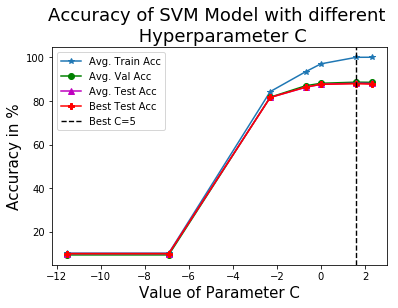

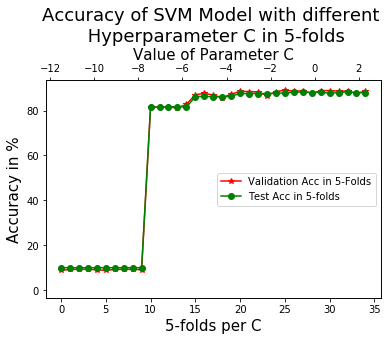

In [61]:
print("\n----------------------Plotting the average Accuracies of 5-fold CV Models\n \
for different values of C=[1e-5, 1e-3, 0.1, 0.5, 1, 5, 10]---------------\n")

C=[1e-5, 1e-3, 0.1, 0.5, 1, 5, 10]
x = range(35)
val_acc_folds = [0.088, 0.0924, 0.0924, 0.093, 0.0908, \
                 0.088, 0.0924, 0.0924, 0.093, 0.0908, \
                 0.8158, 0.8144, 0.8154, 0.8114, 0.8278, \
                 0.8706, 0.8762, 0.8694, 0.857, 0.8732, \
                 0.8852, 0.8848, 0.8824, 0.8666, 0.8842, \
                 0.8904, 0.8866, 0.887, 0.8772, 0.888, \
                 0.8892, 0.886, 0.8868, 0.8764, 0.8866]
val_acc_folds = [x*100 for x in val_acc_folds]

test_acc_folds = [0.1, 0.1, 0.1, 0.1, 0.1,\
                  0.1, 0.1, 0.1, 0.1, 0.1,\
                  0.8152, 0.8146, 0.8166, 0.817, 0.8156,\
                  0.8612, 0.8632, 0.8612, 0.8604, 0.8636,\
                  0.876, 0.8754, 0.8756, 0.8758, 0.8766,\
                  0.8786, 0.8808, 0.884, 0.879, 0.8822,\
                  0.8768, 0.8796, 0.8838, 0.8786, 0.8798]
test_acc_folds = [x*100 for x in test_acc_folds]

fold_chosen=[1, 1, 4, 1, 0, 0, 0]
avg_train_acc = [10.2, 10.2, 84.246, 93.37, 96.98, 99.974, 100.0]
avg_val_acc = [9.4, 9.4, 81.69, 86.928, 88.064, 88.584, 88.5]
avg_test_acc = [10, 10, 81.58, 86.192, 87.588, 88.092, 87.972]
test_acc_best = [10, 10, 81.56, 86.32, 87.6, 87.86, 87.68]

fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.plot(np.log(C), avg_train_acc, marker='*', label='Avg. Train Acc')
ax.plot(np.log(C), avg_val_acc, marker='o', c='g',label='Avg. Val Acc')
ax.plot(np.log(C), avg_test_acc, marker='^', c='m', label='Avg. Test Acc')
ax.plot(np.log(C), test_acc_best, marker='P', c='r', label='Best Test Acc')
ax.axvline(np.log(5), c = 'k', linewidth=1.4, linestyle='--', label='Best C=5')
ax.set_ylabel("Accuracy in %", fontsize=15)
ax.set_xlabel("Value of Parameter C", fontsize=15)
ax.set_title("Accuracy of SVM Model with different \n Hyperparameter C", fontsize=18)
ax.legend()
#plt.savefig('acc_para_c_part2d.png', dpi=1000, bbox_inches='tight')
plt.show()

fig = plt.figure(2)
ax = fig.add_subplot(111)
ax.plot(x, val_acc_folds, marker='*', c='r',label='Validation Acc in 5-Folds')
ax.plot(x, test_acc_folds, marker='o', c='g',label='Test Acc in 5-folds')
ax.set_ylabel("Accuracy in %", fontsize=15)
ax.set_xlabel("5-folds per C", fontsize=15)
ax.set_title("Accuracy of SVM Model with different \n Hyperparameter C in 5-folds", fontsize=18)
ax.legend(loc=7)
ax1 = ax.twiny()
ax1.set_xlabel("Value of Parameter C", fontsize=15)
ax1.plot(np.log(C), np.ones(7), c='w') # Create a dummy plot
#plt.savefig('acc_para_c_folds_part2d.png', dpi=1000, bbox_inches='tight')
plt.show()